In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from deap import base, creator, tools, algorithms
from scipy.stats import spearmanr
import time
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
df = pd.read_csv(r"1.1-Output/ProcessedFeatures.csv")
y = pd.read_csv(r"1.1-Output/ProcessedLabels.csv")

In [3]:
df.drop(columns=['ICMP Code', 'ICMP Type', 'Src Port', 'Dst Port', 'Protocol', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Count'], inplace=True)

In [4]:
y_encoded = LabelEncoder().fit_transform(y.values.ravel())
X_values = df.values
n_features = df.shape[1]

#### SAMPLING

In [5]:
# Set sample size
sample_size = 200_000

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Perform the split
for _, sample_index in sss.split(df, y_encoded):
    if isinstance(df, pd.DataFrame):
        X_sampled = df.iloc[sample_index]
    else:
        X_sampled = df[sample_index]
        
    if isinstance(y_encoded, pd.Series):
        y_sampled = y_encoded.iloc[sample_index]
    else:
        y_sampled = y_encoded[sample_index]

In [6]:
# After sampling
constant_in_sample = np.where(np.std(X_sampled, axis=0) == 0)[0]
print(f"Constant columns in sampled data: {df.columns[constant_in_sample].tolist()}")

Constant columns in sampled data: []


In [7]:
X_values_sampled = X_sampled.values

#### BENCHMARKING

In [8]:
# === Benchmark one individual ===
n_select = 15
selected_indices = np.random.choice(range(n_features), n_select, replace=False)
sample_individual = [1 if i in selected_indices else 0 for i in range(n_features)]

def evaluate(individual):
    start_time = time.time()
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]

    if len(selected_indices) == 0 or len(selected_indices) > 25:
        return -999.0,

    selected_X = X_values_sampled[:, selected_indices]

    # Relevance: mean absolute Spearman correlation with target
    relevance_scores = []
    for i in range(len(selected_indices)):
        feature = selected_X[:, i]
        if np.std(feature) == 0:
            continue  # Skip constant feature
        corr, _ = spearmanr(feature, y_sampled)
        if not np.isnan(corr):
            relevance_scores.append(abs(corr))
    relevance = np.nanmean(relevance_scores) if relevance_scores else 0

    # Redundancy: mean pairwise absolute correlation (skip constant columns)
    if len(selected_indices) > 1:
        valid_cols = [i for i in range(selected_X.shape[1]) if np.std(selected_X[:, i]) != 0]
        if len(valid_cols) > 1:
            valid_X = selected_X[:, valid_cols]
            corr_matrix = np.corrcoef(valid_X, rowvar=False)
            upper_triangle = np.triu_indices(len(valid_cols), k=1)
            redundancy = np.mean(np.abs(corr_matrix[upper_triangle]))
        else:
            redundancy = 0
    else:
        redundancy = 0

    size_penalty = len(selected_indices) / n_features
    score = relevance - redundancy - 0.5 * size_penalty

    print(f"Eval: {len(selected_indices)} features in {time.time() - start_time:.2f}s | Score: {score:.4f}")
    return score,


# === Run single evaluation
evaluate(sample_individual)

Eval: 15 features in 0.52s | Score: -0.0627


(-0.06267452948795527,)

#### FITNESS FUNCTION

In [9]:
def evaluate(individual):
    start_time = time.time()
    selected_indices = [i for i, bit in enumerate(individual) if bit == 1]

    if len(selected_indices) == 0:
        return -999.0,  # Penalize invalid or large sets

    selected_X = X_values_sampled[:, selected_indices]

    # Relevance: mean absolute Spearman correlation with target
    relevance_scores = []
    for i in range(len(selected_indices)):
        feature = selected_X[:, i]
        if np.std(feature) == 0:
            continue
        corr, _ = spearmanr(feature, y_sampled)
        if not np.isnan(corr):
            relevance_scores.append(abs(corr))
    relevance = np.nanmean(relevance_scores) if relevance_scores else 0

    # Redundancy: mean absolute inter-feature correlation
    if len(selected_indices) > 1:
        valid_cols = [i for i in range(selected_X.shape[1]) if np.std(selected_X[:, i]) != 0]
        if len(valid_cols) > 1:
            valid_X = selected_X[:, valid_cols]
            corr_matrix = np.corrcoef(valid_X, rowvar=False)
            upper_triangle = np.triu_indices(len(valid_cols), k=1)
            redundancy = np.mean(np.abs(corr_matrix[upper_triangle]))
        else:
            redundancy = 0
    else:
        redundancy = 0

    # Feature count penalty
    size_penalty = len(selected_indices) / n_features

    # Final fitness score
    score = relevance - redundancy - 0.5 * size_penalty
    print(f"Eval: {len(selected_indices)} features in {time.time() - start_time:.2f}s | Score: {score:.4f}")
    return score,

#### GENETIC ALGORITHM SETUP

In [10]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
# Define a generator that biases towards fewer 1s
def sparse_individual():
    return [1 if random.random() < 0.2 else 0 for _ in range(n_features)]

# Register the sparse individual
toolbox.register("individual", tools.initIterate, creator.Individual, sparse_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
# === GA Parameters ===
POP_SIZE = 30
GENERATIONS = 40
CXPB, MUTPB = 0.5, 0.2

population = toolbox.population(n=POP_SIZE)
halloffame = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# === Run Genetic Algorithm ===
population, logbook = algorithms.eaSimple(
    population, toolbox, cxpb=CXPB, mutpb=MUTPB,
    ngen=GENERATIONS, stats=stats, halloffame=halloffame, verbose=True
)

Eval: 19 features in 0.64s | Score: -0.1055
Eval: 20 features in 0.66s | Score: -0.1489
Eval: 17 features in 0.58s | Score: -0.0163
Eval: 16 features in 0.50s | Score: -0.0551
Eval: 15 features in 0.48s | Score: -0.0319
Eval: 19 features in 0.62s | Score: -0.0629
Eval: 14 features in 0.45s | Score: 0.0117
Eval: 12 features in 0.36s | Score: 0.0741
Eval: 15 features in 0.46s | Score: -0.0125
Eval: 16 features in 0.49s | Score: -0.0098
Eval: 18 features in 0.56s | Score: -0.0555
Eval: 11 features in 0.39s | Score: -0.0664
Eval: 13 features in 0.44s | Score: 0.0087
Eval: 11 features in 0.36s | Score: -0.0390
Eval: 15 features in 0.49s | Score: -0.0228
Eval: 14 features in 0.48s | Score: -0.0213
Eval: 15 features in 0.49s | Score: -0.0618
Eval: 18 features in 0.60s | Score: -0.0449
Eval: 15 features in 0.50s | Score: -0.0133
Eval: 15 features in 0.53s | Score: -0.0359
Eval: 16 features in 0.50s | Score: 0.0135
Eval: 17 features in 0.61s | Score: -0.0105
Eval: 13 features in 0.45s | Score: 

#### IMPLEMENTATION

In [12]:
best_individual = halloffame[0]
best_features = [df.columns[i] for i, bit in enumerate(best_individual) if bit == 1]

print("\n🏆 Best Feature Subset Found:")
print(f"Total selected: {len(best_features)} features out of {n_features}")
print("Selected Features:", best_features)


🏆 Best Feature Subset Found:
Total selected: 7 features out of 76
Selected Features: ['Bwd IAT Max', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'Fwd Segment Size Avg', 'Fwd Seg Size Min', 'Total TCP Flow Time']


In [13]:
log_df = pd.DataFrame(logbook)
print(log_df)

    gen  nevals       avg       min       max
0     0      30 -0.029784 -0.148939  0.074059
1     1      16 -0.005483 -0.110010  0.074059
2     2      15  0.013421 -0.039183  0.074059
3     3      20  0.025800 -0.042960  0.085376
4     4      12  0.045485 -0.023380  0.085376
5     5      14  0.060358  0.009474  0.091838
6     6      22  0.066461  0.000525  0.126690
7     7      16  0.078209  0.017722  0.126690
8     8      20  0.077210 -0.010370  0.126690
9     9      20  0.095817 -0.027389  0.176187
10   10      16  0.102477  0.005838  0.176187
11   11      16  0.111517  0.006109  0.176187
12   12      21  0.126579  0.033512  0.190929
13   13      23  0.140017  0.025817  0.190929
14   14      19  0.153633  0.032536  0.190929
15   15      22  0.177475  0.097064  0.190929
16   16      22  0.178283  0.088397  0.206063
17   17      21  0.183083  0.071130  0.206063
18   18      23  0.181110  0.068135  0.206063
19   19      23  0.185660  0.080037  0.233085
20   20      17  0.193846  0.07665

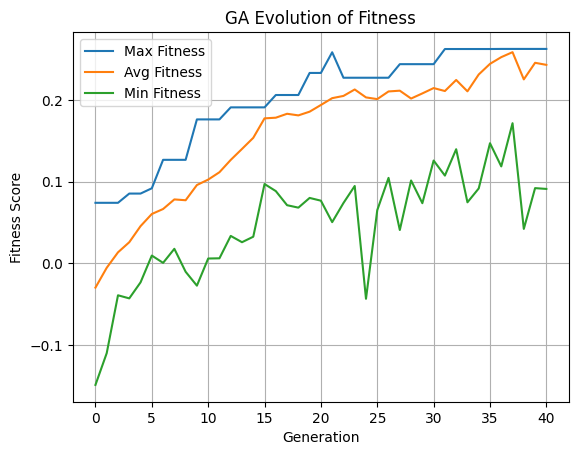

In [14]:
import matplotlib.pyplot as plt

plt.plot(log_df["gen"], log_df["max"], label="Max Fitness")
plt.plot(log_df["gen"], log_df["avg"], label="Avg Fitness")
plt.plot(log_df["gen"], log_df["min"], label="Min Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness Score")
plt.title("GA Evolution of Fitness")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from skfeature.function.similarity_based import fisher_score

In [16]:
# Set sample size
sample_size = 200_000

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Perform the split
for _, sample_index in sss.split(df, y_encoded):
    if isinstance(df, pd.DataFrame):
        X_sampled_eval = df.iloc[sample_index]
    else:
        X_sampled_eval = df[sample_index]
        
    if isinstance(y_encoded, pd.Series):
        y_sampled_eval = y_encoded.iloc[sample_index]
    else:
        y_sampled_eval = y_encoded[sample_index]

In [17]:
X_sampled_eval_best = X_sampled_eval[best_features]
X_sampled_eval_values = X_sampled_eval_best.values

In [18]:
mi = mutual_info_classif(X_sampled_eval_values, y_sampled_eval, discrete_features='auto')
print(f"\nMean Mutual Information (MI): {np.mean(mi):.4f}")


Mean Mutual Information (MI): 0.5561


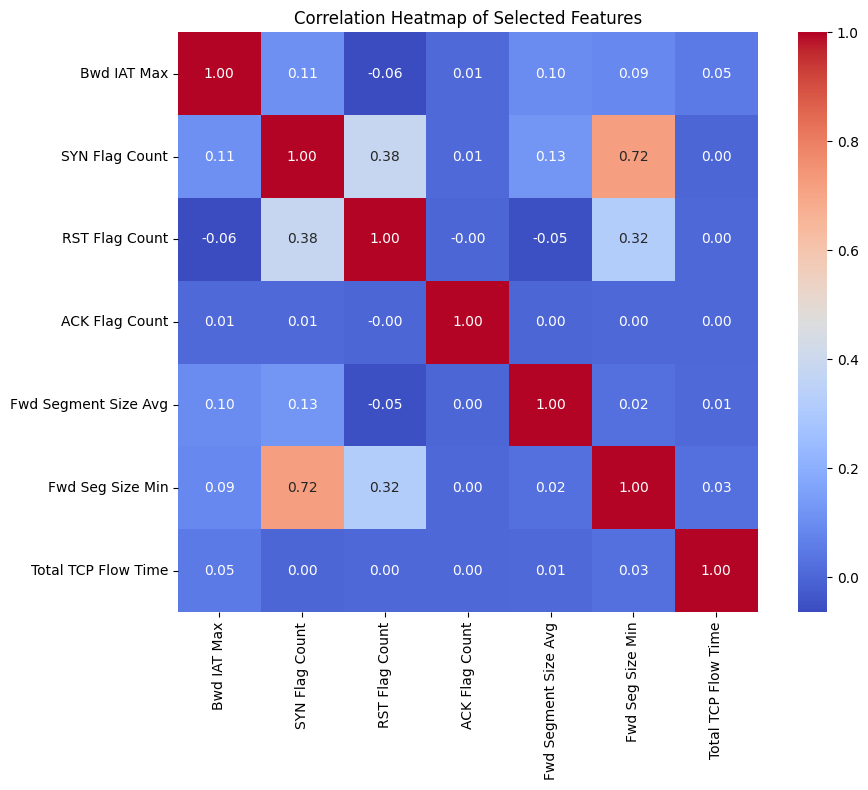

In [19]:
plt.figure(figsize=(10, 8))
corr_matrix = X_sampled_eval_best.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title("Correlation Heatmap of Selected Features")
plt.tight_layout()
plt.show()

In [23]:
# Set sample size
sample_size = 10000

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=sample_size, random_state=42)

# Perform the split
for _, sample_index in sss.split(df, y_encoded):
    if isinstance(df, pd.DataFrame):
        X_vis = df.iloc[sample_index]
    else:
        X_vis = df[sample_index]
        
    if isinstance(y_encoded, pd.Series):
        y_vis = y_encoded.iloc[sample_index]
    else:
        y_vis = y_encoded[sample_index]

In [25]:
from openTSNE import TSNE

# Run openTSNE
tsne = TSNE(
    n_jobs=8,  # parallel processing
    perplexity=30,
    metric="euclidean",
    random_state=42
)
X_tsne = tsne.fit(X_vis.values)

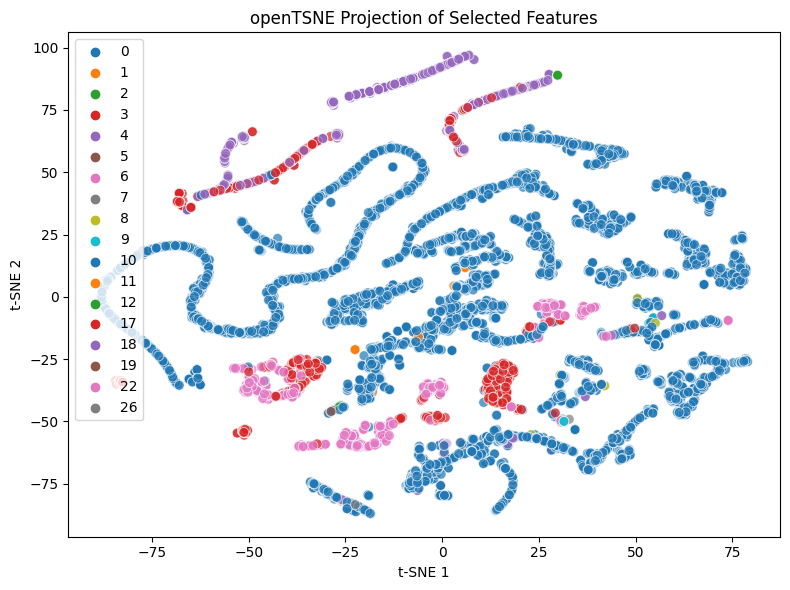

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_vis, palette='tab10', s=50, alpha=0.7)
plt.title("openTSNE Projection of Selected Features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()